<a href="https://www.kaggle.com/code/shedai/customer-segmentation?scriptVersionId=123979493" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [164]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/retail-data-set/file_out.csv


Welcome to the customer segmentation study. This notebook will explain all the steps for customer segmentation. We will start with k-means algorithm and show you the sidebacks of the k-means. Next we will calculate the RFM value manually and show you the adv/disadv of this approach. Finally we will use a library for the RFM calculation. 

**Outline:**
1. EDA
2. Data Visualization
3. Customer Segmentation (RFM) with K-Means
- Recency 
- Frequency
- Monetary
- All together RFM
- Segmentation with K-Means
4.  Segmentation with LifeTimes Library


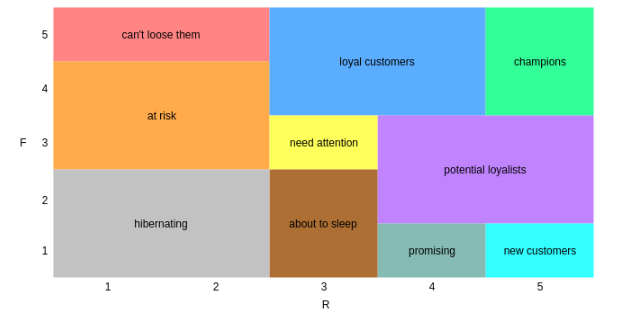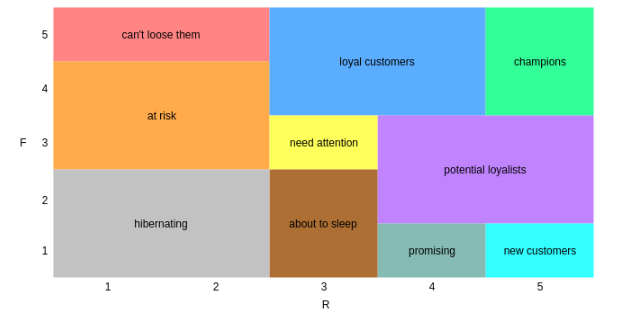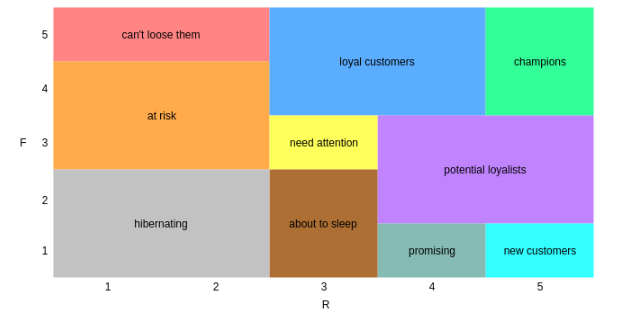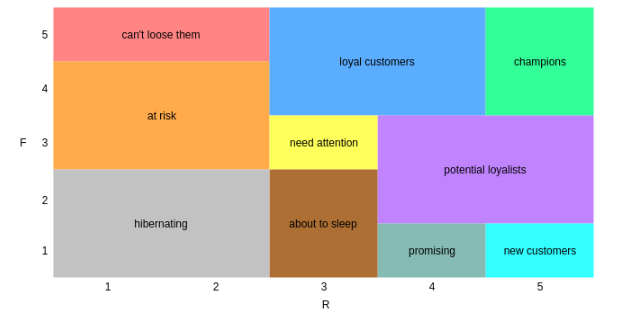](http://)

# 1. EDA
Let's start with some data discovery and exploratory analysis.

In [165]:
df = pd.read_csv('/kaggle/input/retail-data-set/file_out.csv')
df.head()

,Unnamed: 0,DocumentID,Date,SKU,Price,Discount,Customer,Quantity
0,0,716,2019-09-23,1039,381.78,67.37254,1,1.0
1,1,716,2019-09-23,853,593.22,0.00034,1,1.0
2,2,716,2019-09-23,862,423.73,-0.00119,1,1.0
3,3,716,2019-09-23,868,201.70,35.58814,1,1.0
4,4,716,2019-09-23,2313,345.76,61.01966,1,1.0


First column is useless for the pandas dataframe

In [166]:
df.drop(df.columns[0],axis = 1,inplace = True)
df.head()

,DocumentID,Date,SKU,Price,Discount,Customer,Quantity
0,716,2019-09-23,1039,381.78,67.37254,1,1.0
1,716,2019-09-23,853,593.22,0.00034,1,1.0
2,716,2019-09-23,862,423.73,-0.00119,1,1.0
3,716,2019-09-23,868,201.70,35.58814,1,1.0
4,716,2019-09-23,2313,345.76,61.01966,1,1.0


Let's discover the data set, and start some EDA. 

In [167]:
df.shape

(33356, 7)

In [168]:
df.dtypes

DocumentID      int64
Date           object
SKU             int64
Price         float64
Discount      float64
Customer        int64
Quantity      float64
dtype: object

In [169]:
df.describe()

,DocumentID,SKU,Price,Discount,Customer,Quantity
count,33356.000000,33356.000000,33356.000000,33356.000000,33356.000000,33356.000000
mean,8227.577227,1241.273174,2915.716875,591.249968,307.968581,5.760695
std,4028.047727,893.872164,10285.512325,3508.983569,162.675166,19.550559
min,0.000000,0.000000,0.000000,-0.004920,0.000000,0.000000
25%,5399.750000,503.000000,661.016949,95.674576,179.000000,2.000000
50%,8733.000000,1008.000000,1203.389830,195.254237,286.000000,4.000000
75%,10857.000000,2078.250000,2572.194915,423.489661,427.000000,4.000000
max,15751.000000,2904.000000,522767.340000,240396.660000,605.000000,1246.000000


Above table only displays the numerical columns. What about the dates of the data? Let's check the starting and ending dates of the data set:

In [170]:
print(df['Date'].min(), df['Date'].max())

2019-01-01 2022-11-09


Dates covered are between the first day of 2019 to Nov. 2022. 

Now let's focus on the customers and segmentation:

In [171]:
df['Customer'].value_counts()

284    4227
396     785
286     627
418     608
359     588
       ... 
394       1
102       1
589       1
550       1
73        1
Name: Customer, Length: 606, dtype: int64

so, we understand there are some customers with only one time purchases and some customers with hundreds of orders. also there is an outlier customer with ID = 284. 

Now let's get the summary of each product, transaction and customer

In [172]:
pd.DataFrame([{'products': len(df['SKU'].value_counts()),    
               'transactions': len(df['DocumentID'].value_counts()),
               'customers': len(df['Customer'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,2905,15752,606


# 2. Data Visualization
As a part of EDA, we also can visualize the data to understand it in a better way. 

<AxesSubplot:>

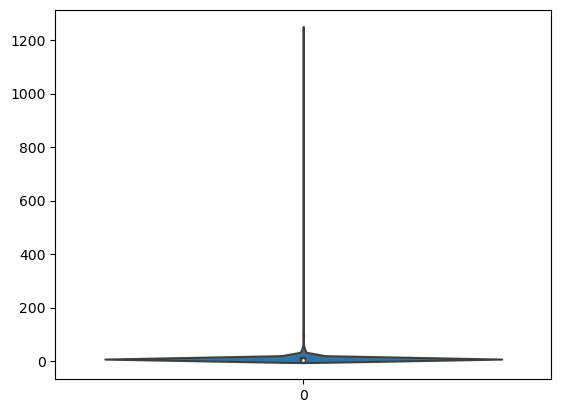

In [173]:
import seaborn as sns
sns.violinplot(df.Quantity)

<AxesSubplot:>

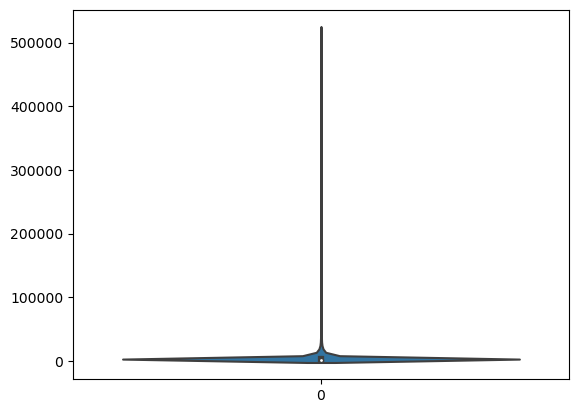

In [174]:
sns.violinplot(df.Price)

<Figure size 1500x600 with 0 Axes>

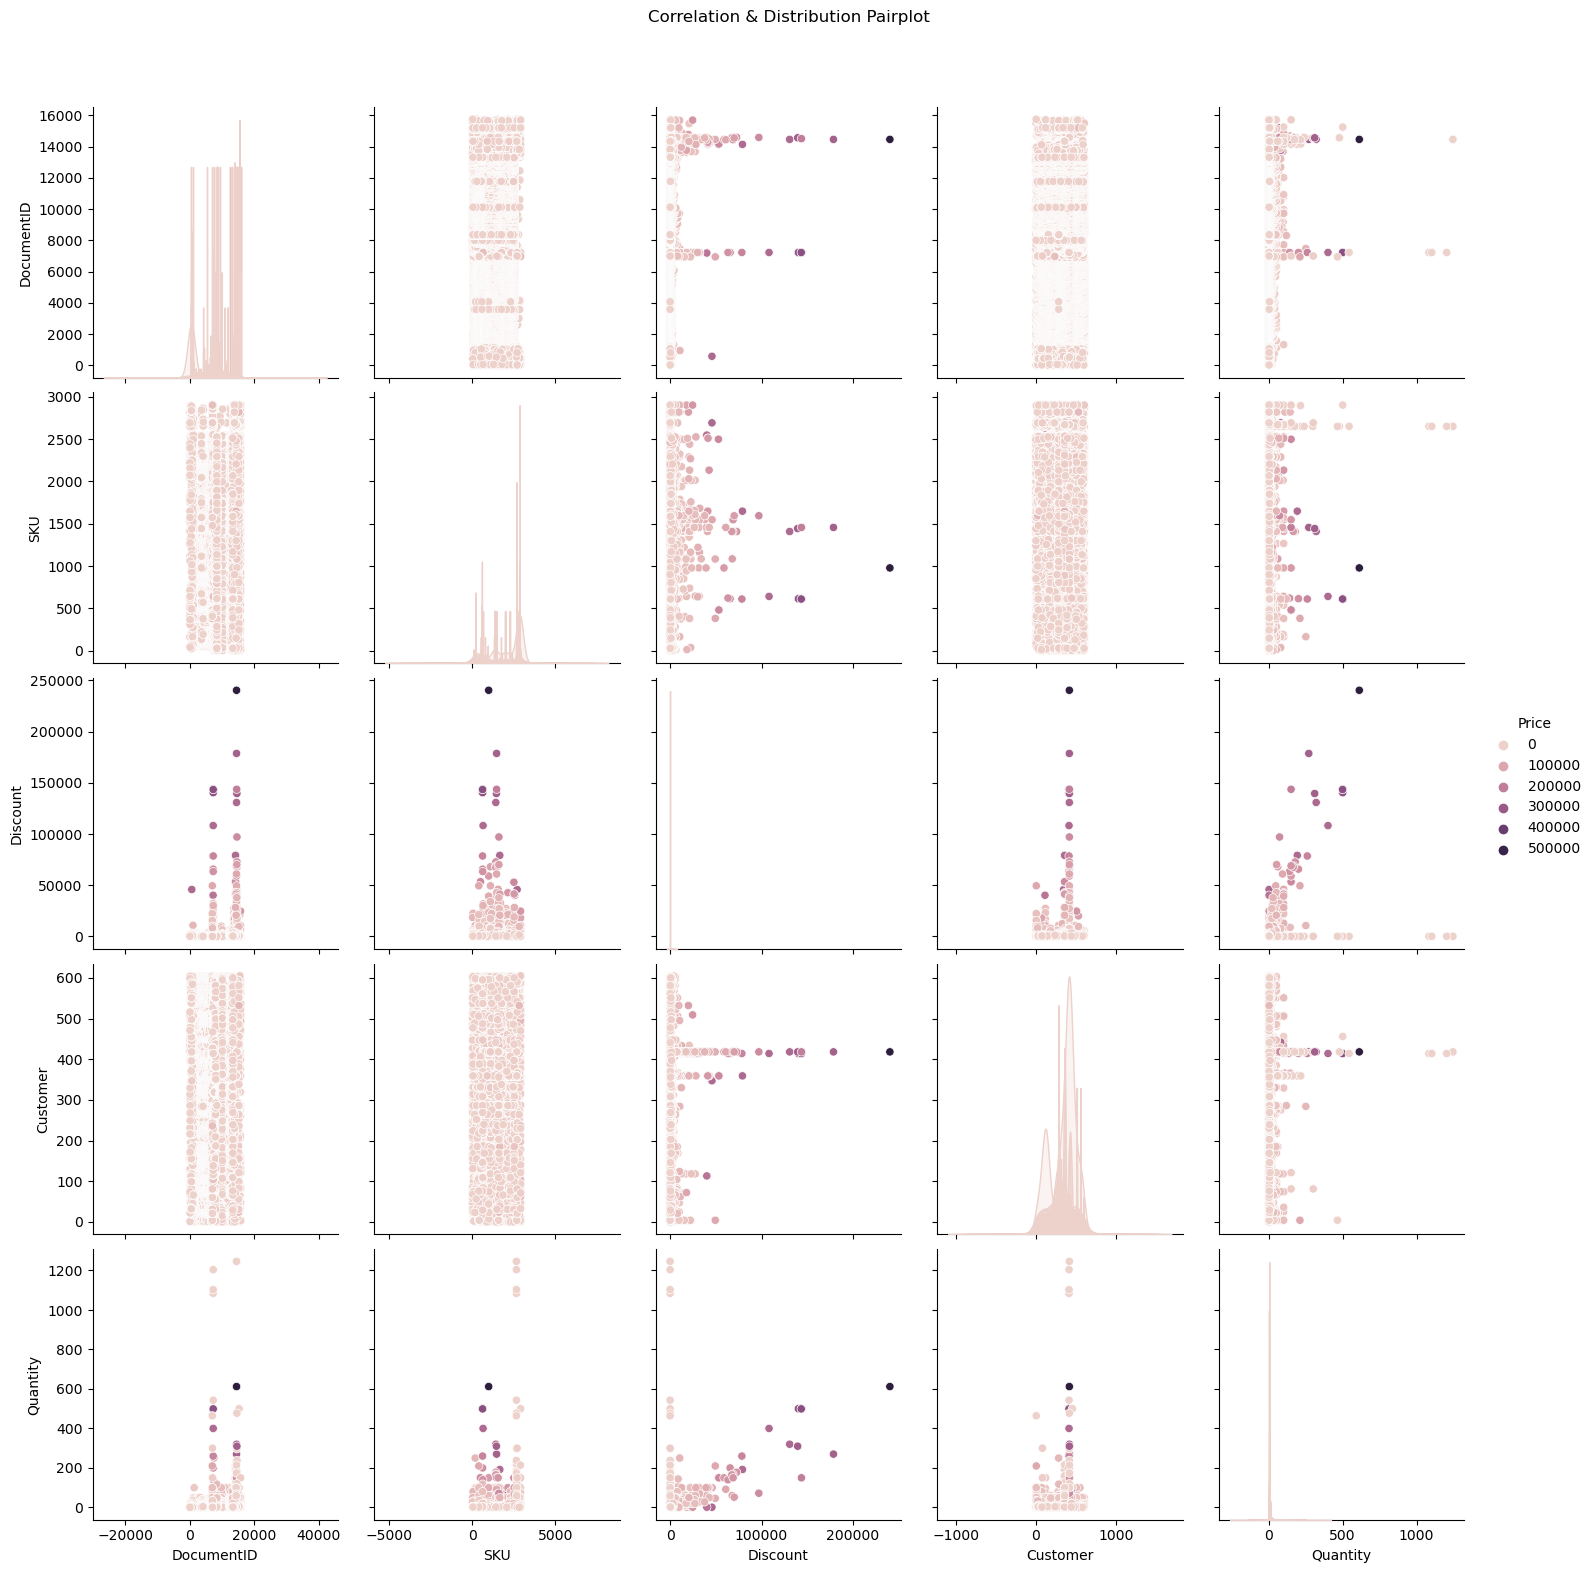

In [175]:
plt.figure(figsize = (15, 6))
sns.pairplot(df, hue = "Price", height = 3)
plt.suptitle("Correlation & Distribution Pairplot", y=1.05)
plt.show()

# 3. Customer Segmentation with RFM
This notebook is about customer segmentation with using the sales data in retail industry. We will use the RFM (recency-frequency-monetory) technique for customer segmentation.

RFM is a method used for analyzing customer value. It is commonly used in database marketing and direct marketing and has received particular attention in retail and professional services industries

**RFM stands for the three dimensions:**

- Recency – How recently did the customer purchase?
- Frequency – How often do they purchase?
- Monetary Value – How much do they spend?

In [176]:
# lets start with basic data transformation necessary for frequency and recency calculations
df['Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d')

**3.1. Recency Data Frame**

In [177]:
#group by customer by Recency (the last date they purchased any product)

recency_df = df.groupby(['Customer'],as_index=False)['Date'].max()
recency_df.columns = ['CustomerID','LastPurchaseDate']
recency_df.head()

,CustomerID,LastPurchaseDate
0,0,2022-11-09
1,1,2021-03-20
2,2,2022-09-09
3,3,2022-10-30
4,4,2022-10-27


In [178]:
#use latest date in our data as current date 
#(for the recency and frequency calculations)

import datetime as dt
now =df['Date'].max()
now

Timestamp('2022-11-09 00:00:00')

In [179]:
#calculate Frequency (how often he is purchasing with reference to latest date in days)
recency_df['Recency'] = recency_df.LastPurchaseDate.apply(lambda x : (now - x).days)
recency_df.head()

,CustomerID,LastPurchaseDate,Recency
0,0,2022-11-09,0
1,1,2021-03-20,599
2,2,2022-09-09,61
3,3,2022-10-30,10
4,4,2022-10-27,13


In [180]:
#we dont need the last purchase date column anymore
recency_df.drop(columns=['LastPurchaseDate'],inplace=True)
recency_df.head()

,CustomerID,Recency
0,0,0
1,1,599
2,2,61
3,3,10
4,4,13


**3.2. Frequency Data Frame**

In [181]:
#Lets create frequency DF of customer 
# based on how many transaction has been done

frequency_df = df.copy()
frequency_df.drop_duplicates(subset=['Customer','DocumentID'], keep="first", inplace=True) 
frequency_df = frequency_df.groupby('Customer',as_index=False)['DocumentID'].count()
frequency_df.columns = ['CustomerID','Frequency']
frequency_df.head()

,CustomerID,Frequency
0,0,16
1,1,71
2,2,21
3,3,2
4,4,34


**3.3. Monetary Data Frame**

In [182]:
#calculate how much a customer spend in the each transaction...

df['Total_cost'] = df['Price'] * df['Quantity']
df.head()

,DocumentID,Date,SKU,Price,Discount,Customer,Quantity,Total_cost
0,716,2019-09-23,1039,381.78,67.37254,1,1.0,381.78
1,716,2019-09-23,853,593.22,0.00034,1,1.0,593.22
2,716,2019-09-23,862,423.73,-0.00119,1,1.0,423.73
3,716,2019-09-23,868,201.70,35.58814,1,1.0,201.70
4,716,2019-09-23,2313,345.76,61.01966,1,1.0,345.76


In [183]:
#check summed up spend of a customer with respect to latest date..

monetary_df=df.groupby('Customer',as_index=False)['Total_cost'].sum()
monetary_df.columns = ['CustomerID','Monetary']

**3.4. RFM From Recency , Frequency, Monetary**

In [184]:
#Combine all three data frames into a single data frame a

#recency and frequency combined
rf = recency_df.merge(frequency_df,left_on='CustomerID',right_on='CustomerID')

#combibe rf frame with monetary values

rfm = rf.merge(monetary_df,left_on='CustomerID',right_on='CustomerID')

rfm.set_index('CustomerID',inplace=True)
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
0,0,16,3.783053e+05
1,599,71,7.880891e+05
2,61,21,1.971703e+05
3,10,2,5.261606e+03
4,13,34,4.511719e+07


**3.5. KMEANS clustering with Elbow Technique**

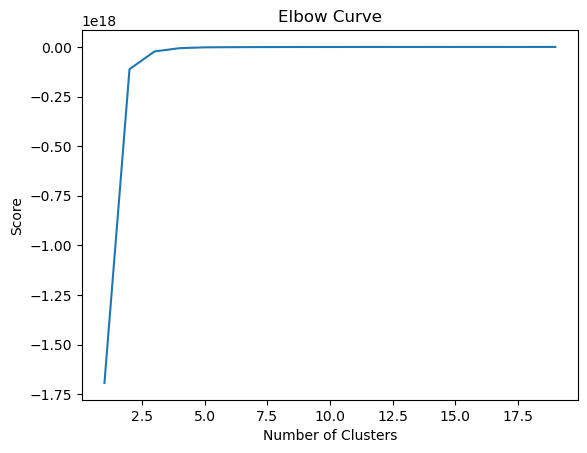

In [185]:
rfm_segmentation = rfm.copy()
from sklearn.cluster import KMeans
# get right number of cluster for K-means so we neeed to loop from 1 to 20 number of cluster and check score.
#Elbow method is used to represnt that. 
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(rfm_segmentation).score(rfm_segmentation) for i in range(len(kmeans))]
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

Elbow technique shows the number of clusters in the graph. Above graph also shows the best cluster number might be 2 or 3. For this notebook, we will continue with 3 clusters. 

In [186]:
#fitting data in Kmeans theorem
kmeans = KMeans(n_clusters=3, random_state=0).fit(rfm_segmentation)
# label each row of the dataset with kmeans clusters.
rfm_segmentation['cluster'] = kmeans.labels_
rfm_segmentation[rfm_segmentation.cluster == 0].head()

,Recency,Frequency,Monetary,cluster
CustomerID,,,,
0,0,16,3.783053e+05,0
1,599,71,7.880891e+05,0
2,61,21,1.971703e+05,0
3,10,2,5.261606e+03,0
4,13,34,4.511719e+07,0


In [187]:
rfm_segmentation['cluster'].value_counts()

0    603
1      2
2      1
Name: cluster, dtype: int64

**Important** interpretation of above table is, kmeans can not output a good clustering. The second and third clusters have only 2 and 1 customers while the first cluster has a huge set of 603 customers. The next attempt would be increasing the number of clusters and see the distribution of customers among the clusters. Lets create a for loop for more clusters and their silhouette scores. 

In [188]:
# Silhouette analysis
from sklearn.metrics import silhouette_score
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.5177302101269705
For n_clusters=3, the silhouette score is 0.543498418705134
For n_clusters=4, the silhouette score is 0.6270386741666049
For n_clusters=5, the silhouette score is 0.6302631356023558
For n_clusters=6, the silhouette score is 0.5788569952318615
For n_clusters=7, the silhouette score is 0.5710164441956581
For n_clusters=8, the silhouette score is 0.5793073213813041


In [189]:
#lets even try 7 clusters

kmeans = KMeans(n_clusters=7, random_state=0).fit(rfm_segmentation)
# label each row of the dataset with kmeans clusters.
rfm_segmentation['cluster'] = kmeans.labels_
rfm_segmentation[rfm_segmentation.cluster == 0].head()

,Recency,Frequency,Monetary,cluster
CustomerID,,,,
0,0,16,378305.254239,0
1,599,71,788089.140330,0
2,61,21,197170.271172,0
3,10,2,5261.605763,0
5,489,1,300.847458,0


In [190]:
rfm_segmentation['cluster'].value_counts()

0    537
5     39
4     18
3      6
6      3
1      2
2      1
Name: cluster, dtype: int64

Again the clustering with k-means yields a very imbalanced distribtuion among the clusters. Lets try the lifetimes library for the RFM and CLV. 

# 4. LifeTimes Library

In [191]:
#lets install the library first
!pip install lifetimes

In [192]:
#lets remember the original dataframe 
df.head()

,DocumentID,Date,SKU,Price,Discount,Customer,Quantity,Total_cost
0,716,2019-09-23,1039,381.78,67.37254,1,1.0,381.78
1,716,2019-09-23,853,593.22,0.00034,1,1.0,593.22
2,716,2019-09-23,862,423.73,-0.00119,1,1.0,423.73
3,716,2019-09-23,868,201.70,35.58814,1,1.0,201.70
4,716,2019-09-23,2313,345.76,61.01966,1,1.0,345.76


RFM calculation with lifetimes library and assignment of recency, frequency and monetary classes. 

In [193]:

from lifetimes.utils import summary_data_from_transaction_data
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def RClass(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMClass(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

grp_df = df.groupby('Customer').Total_cost.sum().sort_values(ascending = False)

lf_data = summary_data_from_transaction_data(
    df, 'Customer', 'Date', monetary_value_col = 'Total_cost', 
    observation_period_end = now)

 
lf_data['frequency']=lf_data['frequency'].astype(int)
lf_data['recency']=lf_data['recency'].astype(int)
lf_data['T']=lf_data['T'].astype(int)
lf_data['monetary_value']=lf_data['monetary_value'].astype(int)

lf_data.head()

,frequency,recency,T,monetary_value
Customer,,,,
0,11,298,298,34269
1,61,761,1360,12915
2,20,1179,1240,7729
3,1,148,158,2526
4,11,124,137,1281164


Now, lets assing the classes from the real RFM classes: 


    r'[1-2][1-2]': 'Hibernate',
    r'[1-2][3-4]': 'Risk', 
    r'[1-2]5': 'Cant Lose',
    r'3[1-2]': 'Sleeper', 
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal',
    r'41': 'Promising',
    r'51': 'New Customer',
    r'[4-5][2-3]': 'High Potential',
    r'5[4-5]': 'Champion'


In [195]:

quantiles = lf_data.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

rfmSegmentation = lf_data

rfmSegmentation['R_Quartile'] = rfmSegmentation['recency'].apply(RClass, args=('recency',quantiles,))
rfmSegmentation['F_Quartile'] = rfmSegmentation['frequency'].apply(FMClass, args=('frequency',quantiles,))
rfmSegmentation['M_Quartile'] = rfmSegmentation['monetary_value'].apply(FMClass, args=('monetary_value',quantiles,))

#labeling classes
rfmSegmentation['RFMClass'] = rfmSegmentation.R_Quartile.map(str) \
                            + rfmSegmentation.F_Quartile.map(str) \
                            + rfmSegmentation.M_Quartile.map(str)
 
segt_map = {
    r'[1-2][1-2]': 'Hibernate',
    r'[1-2][3-4]': 'Risk', 
    r'[1-2]5': 'Cant Lose',
    r'3[1-2]': 'Sleeper', 
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal',
    r'41': 'Promising',
    r'51': 'New Customer',
    r'[4-5][2-3]': 'High Potential',
    r'5[4-5]': 'Champion'
}

rfmSegmentation['Segment'] = rfmSegmentation['R_Quartile'].map(str) + rfmSegmentation['F_Quartile'].map(str)
rfmSegmentation['Segment'] =  rfmSegmentation['Segment'].replace(segt_map, regex=True)


In [196]:
rfmSegmentation.head()

,frequency,recency,T,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass,Segment
Customer,,,,,,,,,
0,11,298,298,34269,3,2,1,321,Sleeper
1,61,761,1360,12915,3,1,1,311,Sleeper
2,20,1179,1240,7729,4,2,2,422,High Potential
3,1,148,158,2526,3,3,2,332,Need Attention
4,11,124,137,1281164,3,2,1,321,Sleeper


Let's see the segment distribution of customers now:

In [197]:
rfmSegmentation['Segment'].value_counts()

Risk              289
Promising         123
Sleeper           115
Need Attention     36
High Potential     29
Hibernate          14
Name: Segment, dtype: int64

Now, we have much better segmentation distribution for the segments. Although we dont have all the segments from RFM, we utilize 6 of the segments. 

In [200]:
rfmSegmentation.head()

,frequency,recency,T,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass,Segment
Customer,,,,,,,,,
0,11,298,298,34269,3,2,1,321,Sleeper
1,61,761,1360,12915,3,1,1,311,Sleeper
2,20,1179,1240,7729,4,2,2,422,High Potential
3,1,148,158,2526,3,3,2,332,Need Attention
4,11,124,137,1281164,3,2,1,321,Sleeper


Also let's see the segments and whole data sorted by the monetary_value:

In [204]:
rfmSegmentation.sort_values('monetary_value')

,frequency,recency,T,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass,Segment,monetary_val_pos
Customer,,,,,,,,,,
302,0,0,1241,0,1,4,4,144,Risk,0
334,0,0,1069,0,1,4,4,144,Risk,0
333,0,0,83,0,1,4,4,144,Risk,0
326,0,0,1330,0,1,4,4,144,Risk,0
324,0,0,1339,0,1,4,4,144,Risk,0
...,...,...,...,...,...,...,...,...,...,...
286,64,114,114,673264,3,1,1,311,Sleeper,673264
4,11,124,137,1281164,3,2,1,321,Sleeper,1281164
359,77,318,320,3907646,3,1,1,311,Sleeper,3907646


Another important value for the customers is the customer lifetime value (CLV).
We can use the BetaGeoFitter and GammaGammaFitter together from the lifetimes library again. One important point about our dataset is, there are some customers with monetary value is 0. This is a problem for the convergence of the model and we divide the data set into two parts. The first part with monetary_value = 0 is set to CLV = 0 manually and the second part where the monetary_value > 0 is getting the CLV calculation from the GammaGammaFitter.

In [205]:


#ConvergenceError: 
#The model did not converge. Try adding a larger penalizer to see if that helps convergence.
#Train the BG/NBD model

df_clv = rfmSegmentation

from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(df_clv['frequency'], df_clv['recency'], df_clv['T'])

from lifetimes import GammaGammaFitter

rfmSegmentation2 = rfmSegmentation[rfmSegmentation['monetary_value']>0]
rfmSegmentation1 = rfmSegmentation[rfmSegmentation['monetary_value']==0]
rfmSegmentation1['CLV']  = 0

GGF=GammaGammaFitter(penalizer_coef=0)

GGF.fit(rfmSegmentation2["frequency"],rfmSegmentation2["monetary_val_pos"])

rfmSegmentation2["CLV"]=GGF.customer_lifetime_value(bgf, rfmSegmentation2["frequency"], rfmSegmentation2["recency"], rfmSegmentation2["T"], rfmSegmentation2["monetary_val_pos"], time=12, discount_rate=0.01, freq="D")
rfm_Seg = pd.concat([rfmSegmentation1, rfmSegmentation2])
rfm_Seg.head()
#yazdir(rfmSegmentation)


,frequency,recency,T,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass,Segment,monetary_val_pos,CLV
Customer,,,,,,,,,,,
5,0,0,489,0,1,4,4,144,Risk,0,0.0
8,0,0,27,0,1,4,4,144,Risk,0,0.0
9,0,0,1094,0,1,4,4,144,Risk,0,0.0
10,0,0,78,0,1,4,4,144,Risk,0,0.0
11,0,0,358,0,1,4,4,144,Risk,0,0.0


In [206]:
rfm_Seg.sort_values('CLV',ascending = False)

,frequency,recency,T,monetary_value,R_Quartile,F_Quartile,M_Quartile,RFMClass,Segment,monetary_val_pos,CLV
Customer,,,,,,,,,,,
418,71,151,155,12252231,3,1,1,311,Sleeper,12252231,1.649670e+09
414,12,118,125,47050591,3,2,1,321,Sleeper,47050591,1.341089e+09
359,77,318,320,3907646,3,1,1,311,Sleeper,3907646,2.953988e+08
286,64,114,114,673264,3,1,1,311,Sleeper,673264,1.085326e+08
433,50,182,186,540767,3,1,1,311,Sleeper,540767,4.382732e+07
...,...,...,...,...,...,...,...,...,...,...,...
400,0,0,154,0,1,4,4,144,Risk,0,0.000000e+00
395,0,0,104,0,1,4,4,144,Risk,0,0.000000e+00
394,0,0,891,0,1,4,4,144,Risk,0,0.000000e+00


Finally, lets see the distribution of each customer segment for the recency, monetary and frequency in the barcharts. 

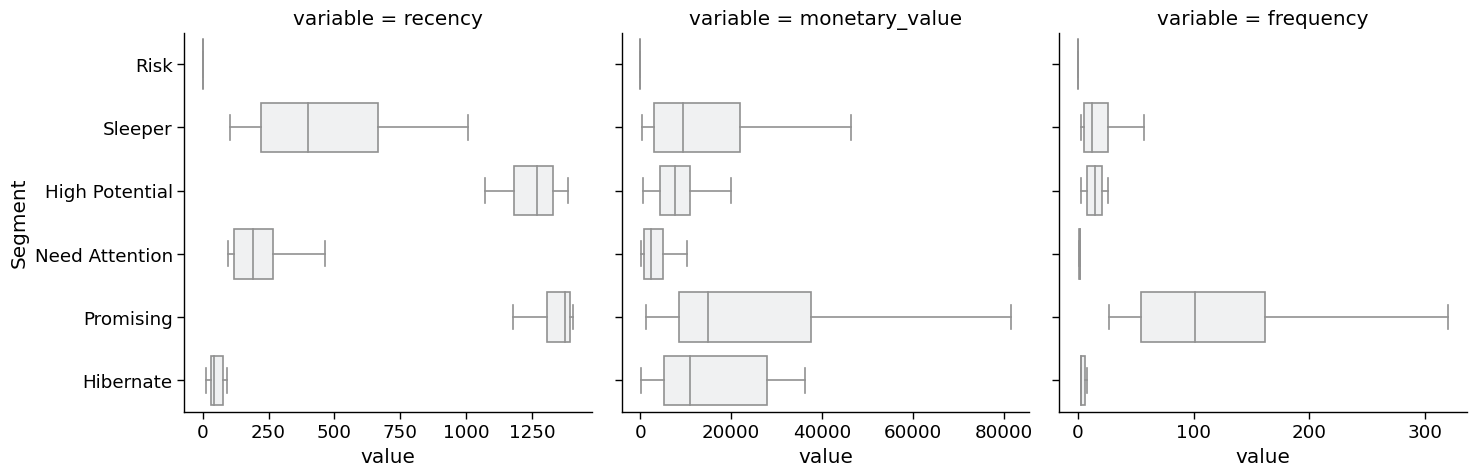

In [232]:
#Creating a final boxplot to see how each segment differentiates
features = ['recency','monetary_value','frequency','Segment']
summary = rfm_Seg[features].melt(id_vars=['Segment']) 

sns.set_context(context = 'paper',font_scale=1.5)
g = sns.FacetGrid(summary, col="variable",sharex=False,height=5)
g.map_dataframe(sns.boxplot, x="value", y="Segment",hue='variable',showfliers=False)

Finally lets try to demonstrate the distribution of segments among the monetary quartile with using the plotly treemap:

In [245]:
import plotly.express as px
fig = px.treemap(rfm_Seg, path=[ 'Segment'], values='M_Quartile')
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()